#### Environment: Kaggle gpu
#### Training + Inference: ~ 1h10min

In [1]:
!nvidia-smi

Sun Aug  7 10:28:20 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.82.01    Driver Version: 470.82.01    CUDA Version: 11.4     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   41C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import pkg_resources

def placeholder(x):
    raise pkg_resources.DistributionNotFound
pkg_resources.get_distribution = placeholder

!pip uninstall fastai fastcore torchaudio torchvision -y
!pip install fastaudio
!pip install torch==1.8.1 torchaudio==0.8.1 fastcore==1.3.20 torchvision==0.9.1 librosa==0.8.1
!pip install -q efficientnet_pytorch

In [4]:
import os
import random
import pandas as pd
import numpy as np
import torch
import torchaudio
from efficientnet_pytorch import EfficientNet
from sklearn.model_selection import StratifiedKFold
from fastai.vision.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

import warnings
warnings.filterwarnings('ignore')

/opt/conda/lib/python3.7/site-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


In [5]:
path = Path('/kaggle/input/swahili-audio')
wrk_path = Path('/kaggle/working')

In [6]:
train_path = path/'Swahili_words'

In [7]:
seed = 42

def set_seed(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

set_seed(seed)

In [8]:
train = pd.read_csv(path/'Train.csv')
train.shape

(4200, 3)

In [9]:
train.head()

,Word_id,Swahili_word,English_translation
0,id_v8rz06e6rv31.wav,mbili,two
1,id_vmbwicdpfn68.wav,tatu,three
2,id_injlouhxg1hg.wav,ndio,yes
3,id_gdq23p6xgzya.wav,nne,four
4,id_lpstklz51zpz.wav,nane,eight


In [11]:
train['Swahili_word'].value_counts()

mbili     350
tatu      350
ndio      350
nne       350
nane      350
hapana    350
sita      350
tisa      350
moja      350
saba      350
tano      350
kumi      350
Name: Swahili_word, dtype: int64

In [ ]:
train_df = train.copy()
train_df['Word_id'] = train_df['Word_id'].apply(lambda x: f'{train_path}/{x}')

In [14]:
cfg = AudioConfig.Voice()
a2s = AudioToSpec.from_cfg(cfg) 

In [16]:
pipe = Pipeline([AudioTensor.create, a2s])

/kaggle/input/swahili-audio/Swahili_words/id_v8rz06e6rv31.wav


/kaggle/input/swahili-audio/Swahili_words/id_vmbwicdpfn68.wav


/kaggle/input/swahili-audio/Swahili_words/id_injlouhxg1hg.wav


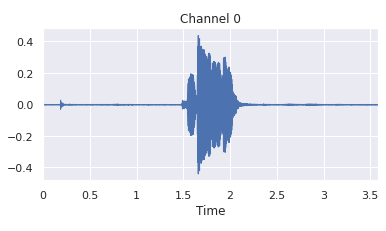

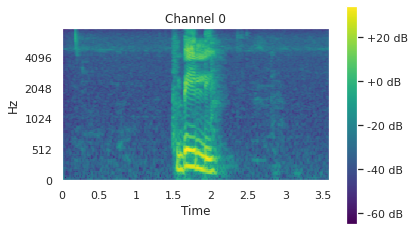

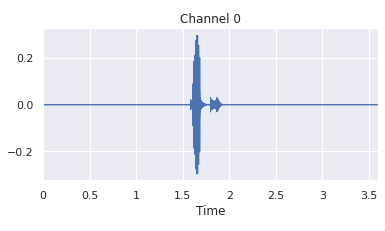

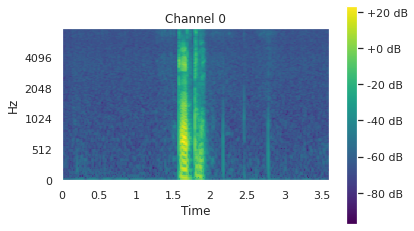

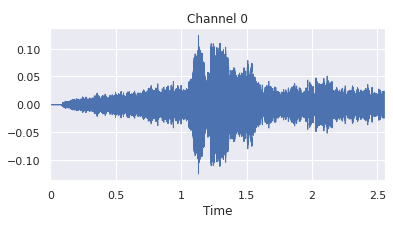

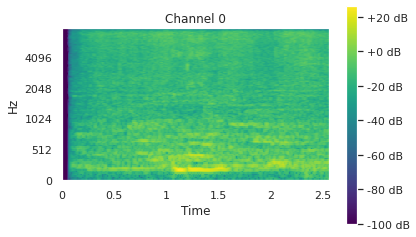

In [17]:
for fn in train_df['Word_id'][:3].values:
    print(fn)
    audio = AudioTensor.create(fn)
    audio.show()
    pipe(fn).show()

In [18]:
bs = 16
item_tfms = [RemoveSilence(), ResizeSignal(7000), a2s, Delta()]

In [19]:
db = DataBlock(
    blocks=(AudioBlock, CategoryBlock),  
    get_x=ColReader('Word_id'), 
    splitter=TrainTestSplitter(
        test_size=0.1,
        stratify=train_df.Swahili_word,
        random_state=seed),
    item_tfms=item_tfms,
    get_y=ColReader('Swahili_word'))
dls = db.dataloaders(train_df, bs=bs)

In [23]:
test = pd.read_csv(path/'Test.csv')
test.shape

(1800, 1)

In [24]:
test.head()

,Word_id
0,id_jp2pxl0r84ya.wav
1,id_ndduqqvthbpx.wav
2,id_36oxymxfcm6q.wav
3,id_ue9b0to760pg.wav
4,id_prja4oprb914.wav


In [ ]:
test_df = test.copy()
test_df['Word_id'] = test_df['Word_id'].apply(lambda x: f'{train_path}/{x}')

In [26]:
test_dl = dls.test_dl(test_df)

In [27]:
model_name = 'efficientnet-b4'
def get_model(dls, pretrained=True, **kwargs):
    model = EfficientNet.from_pretrained(model_name)
    model._fc = nn.Linear(model._fc.in_features, dls.c)
    return model

In [28]:
loss_val, targets = [], []
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=seed)

for train_idx, valid_idx in skf.split(train_df.index, train_df.Swahili_word):
    db = DataBlock(
        blocks=(AudioBlock, CategoryBlock),  
        get_x=ColReader('Word_id'), 
        splitter=IndexSplitter(valid_idx),
        item_tfms=item_tfms,
        get_y=ColReader('Swahili_word'))
    dls = db.dataloaders(train_df, bs=bs)
    learn = Learner(dls, get_model(dls), loss_func=CrossEntropyLossFlat(),
                        metrics=error_rate)
    learn.fine_tune(10)
    loss, acc = learn.validate()    
    loss_val.append(loss)
    preds, _ = learn.tta(dl=test_dl)
    targets.append(preds.numpy().tolist())

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b4-6ed6700e.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b4-6ed6700e.pth


  0%|          | 0.00/74.4M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b4


epoch,train_loss,valid_loss,error_rate,time
0,1.040863,4.789405,0.574286,02:27


epoch,train_loss,valid_loss,error_rate,time
0,0.255668,0.185921,0.048571,02:18
1,0.243005,0.273754,0.066429,02:18
2,0.264366,0.374989,0.092857,02:17
3,0.130587,0.266204,0.058571,02:05
4,0.109079,0.221305,0.049286,01:47
5,0.108192,0.202679,0.050714,01:47
6,0.056084,0.118942,0.025714,01:48
7,0.034607,0.127192,0.027143,01:47
8,0.021411,0.117322,0.021429,01:46
9,0.025560,0.124777,0.022857,01:46


Loaded pretrained weights for efficientnet-b4


epoch,train_loss,valid_loss,error_rate,time
0,1.074397,23.947935,0.882857,01:47


epoch,train_loss,valid_loss,error_rate,time
0,0.237292,0.153648,0.043571,01:46
1,0.247192,0.251651,0.070000,01:49
2,0.248543,0.414282,0.107143,01:48
3,0.193555,0.183284,0.044286,01:47
4,0.104296,0.703168,0.170000,01:47
5,0.100101,0.130298,0.037857,01:47
6,0.073046,0.109730,0.028571,01:47
7,0.045405,0.083583,0.025000,01:47
8,0.029385,0.074366,0.020714,01:47
9,0.022375,0.077914,0.017857,01:46


Loaded pretrained weights for efficientnet-b4


epoch,train_loss,valid_loss,error_rate,time
0,1.052866,5.029788,0.699286,01:45


epoch,train_loss,valid_loss,error_rate,time
0,0.262284,0.194023,0.051429,01:46
1,0.218711,0.578163,0.154286,01:46
2,0.247386,0.363276,0.085000,01:45
3,0.249408,0.282790,0.070000,01:45
4,0.133468,0.133479,0.036429,01:46
5,0.105668,0.125710,0.037143,01:45
6,0.067282,0.086130,0.020714,01:46
7,0.034917,0.086212,0.023571,01:46
8,0.018677,0.082317,0.018571,01:46
9,0.025120,0.086083,0.020714,01:47


CPU times: user 40min 49s, sys: 10min 52s, total: 51min 42s
Wall time: 1h 9min 18s


In [30]:
probas = np.mean(targets, 0)

In [32]:
sub = pd.DataFrame({'Word_id': test['Word_id']})
for i, label in enumerate(learn.dls.vocab):
    sub[label] = probas[:,i]

In [35]:
sub.to_csv(wrk_path/'submission_26.csv', index=False)